In [ ]:
!pip3 install pyro-ppl
!pip3 install sklearn
!pip3 install arviz
!pip3 install numpy
!pip3 install matplotlib
!pip3 install gpytorch
!pip3 install scipy

In [ ]:
import pyro
import torch
import scipy
import pyro.distributions as pdist
import torch.distributions as tdist
import arviz
import numpy as np
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, NUTS
import arviz as az
from torch.distributions import constraints

import matplotlib.pyplot as plt
import math
import torch
import gpytorch
import pyro
from pyro.infer.mcmc import NUTS, MCMC, HMC
from matplotlib import pyplot as plt
from scipy import stats as ss

In [ ]:
def g(x):
    return (- (np.sin(6*np.pi*x))**2 + 6*x**2 - 5*x**4 + 3/2) * (x<=1) * (x>=0)
def data(ell = 30):
  x = (np.arange(1,ell+1)-1) / (ell-1)
  index = np.random.choice(ell, size = 20, replace=False)
  x_train = np.sort(x[index]).reshape(-1,1)
  y_train = np.random.normal(g(x_train), np.sqrt(0.01))
  y_mean = y_train.mean()
  y_std = y_train.std()

  x_test = np.setdiff1d(x,x_train).reshape(-1,1)
  y_test = np.random.normal(g(x_test), np.sqrt(0.01))
  #y_test = (y_test-y_mean)/y_std

  train_x = torch.tensor(x_train.reshape(20,))
  train_y = torch.tensor(y_train.reshape(20,))
  test_x = torch.tensor(x_test.reshape(10,))
  test_y = torch.tensor(y_test.reshape(10,))

  train_y = (train_y - y_mean) / y_std
  test_y = (test_y - y_mean) / y_std
  return train_x, train_y, test_x, test_y, y_mean, y_std

In [ ]:
train_x, train_y, test_x, test_y, y_mean, y_std = data()

## Fit the model using MAP

In [ ]:
def model1():
  # Clear the parameter store
  pyro.clear_param_store()
  # Define the RBF kernel with constant noise
  kernel = gp.kernels.RBF(
      input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(0.05)
  )
  noise_value = torch.tensor(0.01)
  gpr1 = gp.models.GPRegression(train_x, train_y, kernel, noise = noise_value)

  # Set priors on the kernel hyperparameters
  gpr1.kernel.lengthscale = pyro.nn.PyroSample(dist.HalfNormal(0.05))
  gpr1.kernel.variance = pyro.nn.PyroSample(dist.HalfNormal(1))

  # Set a prior on the observation noise (noise parameter)

  # Set up optimizer and loss function
  optimizer = torch.optim.Adam(gpr1.parameters(), lr=0.005)
  loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
  losses = []

  # Training loop
  num_steps = 1500
  for i in range(num_steps):
      optimizer.zero_grad()
      loss = loss_fn(gpr1.model, gpr1.guide)
      loss.backward()
      optimizer.step()
      gpr1.noise = noise_value
      losses.append(loss.item())
  return gpr1

In [ ]:
def model2():
  # Clear the parameter store
  pyro.clear_param_store()
  # Define the RBF kernel with constant noise
  kernel = gp.kernels.RBF(
      input_dim=1, variance=torch.tensor(1.0), lengthscale=torch.tensor(0.05)
  )
  noise_value = torch.tensor(0.01)
  gpr2 = gp.models.GPRegression(train_x, train_y, kernel, noise = noise_value)

  # Set priors on the kernel hyperparameters
  gpr2.kernel.lengthscale = pyro.nn.PyroSample(dist.HalfNormal(0.05))
  gpr2.kernel.variance = pyro.nn.PyroSample(dist.HalfNormal(1.0))


  nuts_kernel = NUTS(gpr2.model)
  mcmc_nuts = MCMC(nuts_kernel, num_samples=500, warmup_steps=400, num_chains=1)
  mcmc_nuts.run()
  return mcmc_nuts, gpr2

In [ ]:
def predictive_posterior(model, sigma2_y = 0.01):
  f_loc, f_cov = model(test_x, full_cov=True)
  return pdist.MultivariateNormal(f_loc, f_cov + sigma2_y * torch.eye(f_cov.size(0))).log_prob(test_y)

In [ ]:
def mod_plot(model):
  f_loc, f_cov = model(torch.tensor(np.linspace(0,1)), full_cov=True)
  f_var = np.diag(f_cov.detach().numpy())
  gp_post_samples = ss.multivariate_normal.rvs(mean=f_loc.detach().numpy(), cov=f_cov.detach().numpy(), size=20)

  plt.plot(np.linspace(0,1), g(np.linspace(0,1)), color = "blue", label = "g(x)")
  yout_m = f_loc.detach().numpy() * y_std + y_mean
  yout_m = yout_m.reshape(50,)
  yout_v = f_var * y_std**2
  plt.plot(np.linspace(0,1), yout_m, color='red', label=r"$\mu_*$")
  plt.fill_between(np.linspace(0,1), yout_m, yout_m + 1.96*(yout_v + 0.01)**0.5, alpha=0.3, color = "grey", label=r"$\pm 1.96 \sqrt{\sigma*^2 + \sigma_y^2}$")
  plt.fill_between(np.linspace(0,1), yout_m, yout_m - 1.96*(yout_v + 0.01)**0.5, alpha=0.3, color = "grey")
  plt.scatter(test_x,test_y * y_std + y_mean, label = "test")
  plt.scatter(train_x,train_y* y_std + y_mean, label = "train")
  plt.legend()
  #plt.savefig("f_star_mod1")
  plt.plot()

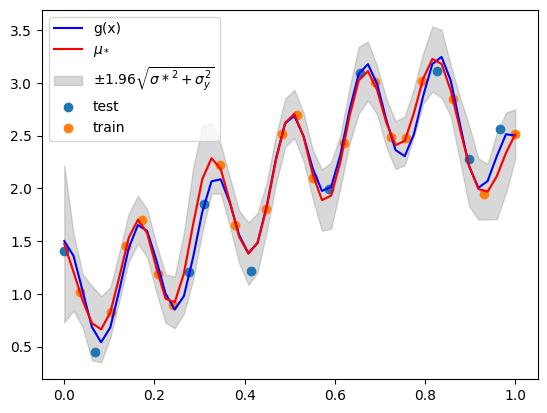

In [ ]:
pyro.clear_param_store()
gpr1 = model1()
mod_plot(gpr1)

In [ ]:
predictive_posterior(gpr1)

tensor(-2.7293, dtype=torch.float64, grad_fn=<SubBackward0>)

Sample: 100%|██████████| 900/900 [00:25, 35.68it/s, step size=5.97e-01, acc. prob=0.939]


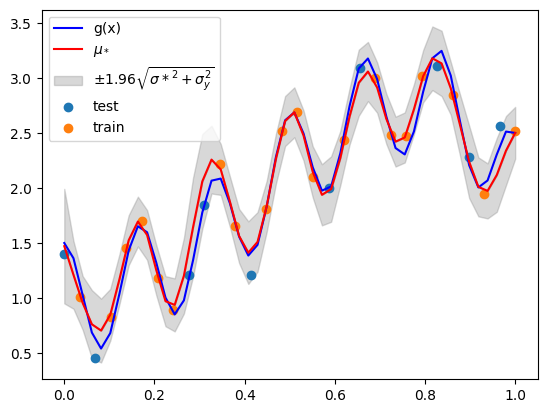

In [ ]:
mcmc_nuts, gpr2 = model2()
mod_plot(gpr2)

In [ ]:
predictive_posterior(gpr2)

tensor(-2.7293, dtype=torch.float64, grad_fn=<SubBackward0>)

/usr/local/lib/python3.10/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(



                          mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel.lengthscale      0.05      0.01      0.05      0.04      0.06    180.53      1.00
     kernel.variance      1.22      0.45      1.14      0.58      1.84    269.40      1.00

Number of divergences: 0
None


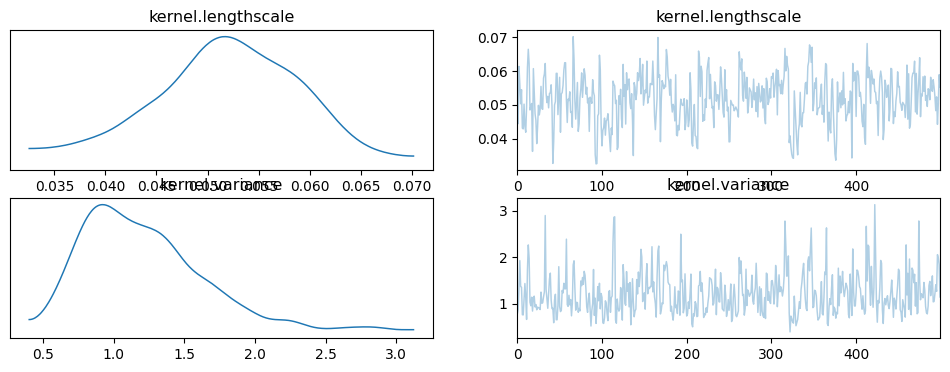

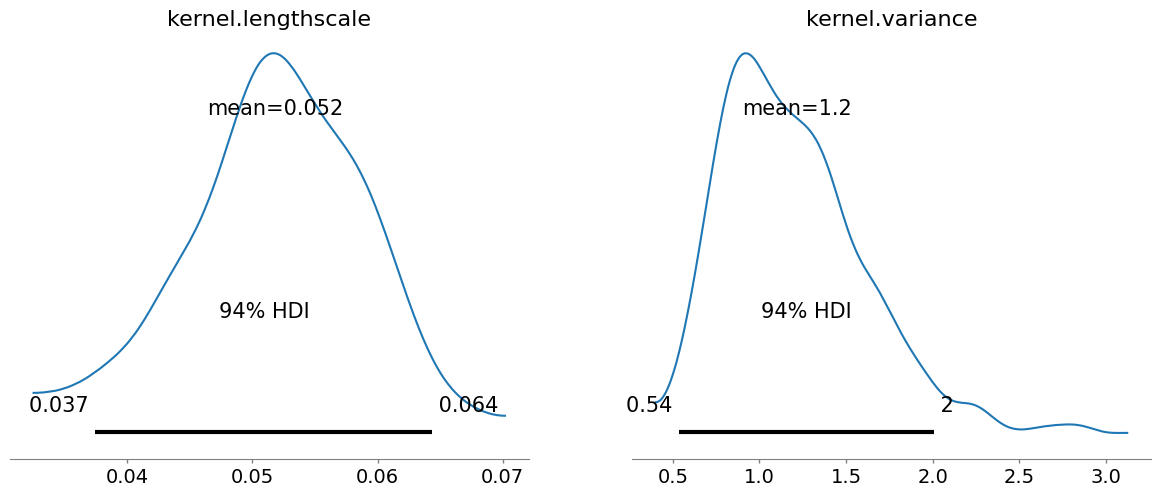

In [ ]:
# inspect visually NUTS
samples = mcmc_nuts.get_samples()
data = az.from_pyro(mcmc_nuts)

print(mcmc_nuts.summary())
az.plot_trace(data)
#plt.savefig("traceplots")
plt.show()
az.plot_posterior(data)
#plt.savefig("posterior_mod2")
plt.show()

In [ ]:
log_like_map = []
log_like_NUTS = []
for i in range(20):
  ll1 = predictive_posterior(model1())
  log_like_map.append(ll1.item())
  ll2 = predictive_posterior(model2()[1])
  log_like_NUTS.append(ll2.item())

Sample: 100%|██████████| 700/700 [00:19, 36.48it/s, step size=7.21e-01, acc. prob=0.932]


In [ ]:
log_like_map = np.array(log_like_map)
log_like_NUTS = np.array(log_like_NUTS)
print(f"mean map: {log_like_map.mean()}")
print(f"sd map: {log_like_map.std()}")
print(f"mean NUTS: {log_like_NUTS.mean()}")
print(f"sd NUTS: {log_like_NUTS.std()}")

mean map: -0.2678953096769264
sd map: 2.945703559001337
mean NUTS: -5.915042579028393
sd NUTS: 8.19041239097694


## B2

In [ ]:
# X and W
ell = 101
X = np.arange(1, ell+1).reshape(-1,1)
X = (X-1)/(ell-1)
W = np.ones(ell).reshape(-1,1)
W[1:-1] = 1 / (ell -1)
W[0] = W[-1] = 1/(2*ell - 2)

In [ ]:
## Udhiver estimater:
k_variance = gpr1.kernel.variance.item()
k_lengthscale = gpr1.kernel.lengthscale.item()
sigma2_y = gpr1.noise.item()

## K matrix
K = k_variance * np.exp(-0.5 * (X - X.T)**2 / k_lengthscale**2)

# Covariance matrix of (hat{q}, f)
cov_q = W.T@K@W
coc_2_1 = K @ W
cov_f = K

In [ ]:
def mu(q):
  return K @ W @ np.linalg.inv(W.T @ K @ W) * q
cov_f_qX = K - K @ W @ np.linalg.inv(W.T@K@W) @ W.T @ K

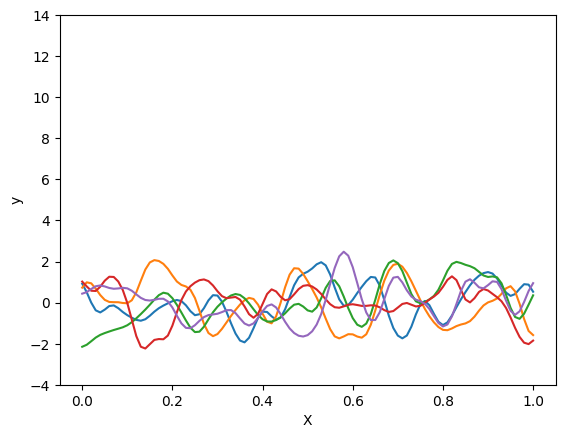

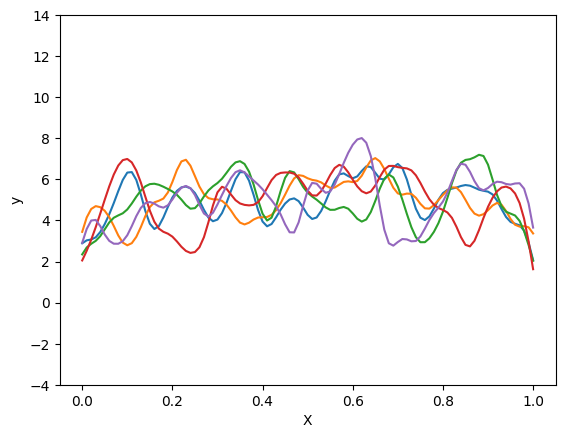

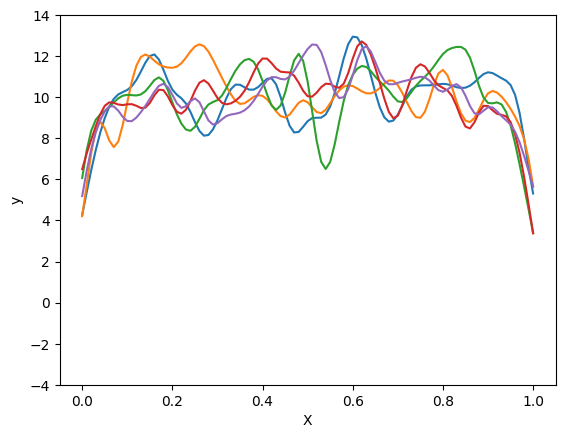

In [ ]:
for q in [0, 5, 10]:
  sample = np.random.multivariate_normal(mu(q=q).squeeze(), cov_f_qX, size=5)
  for i in range(5):
    plt.plot(X, sample[i])
  plt.ylim(-4,14)
  plt.xlabel("X")
  plt.ylabel("y")
  #plt.savefig(f"f_q, hatq={q}")
  plt.show()

### B2(4.1)

In [ ]:
train_x2 = torch.tensor([0.0, 0.25, 0.5], dtype=torch.float64)
train_y2 = torch.tensor([1.46, 0.93, 2.76], dtype=torch.float64)

In [ ]:
# Clear the parameter store
pyro.clear_param_store()
# Define the RBF kernel with constant noise
kernel = gp.kernels.RBF(
    input_dim=1,
    variance=torch.tensor(k_variance),
    lengthscale=torch.tensor(k_lengthscale)
)
gpr2 = gp.models.GPRegression(train_x2, train_y2, kernel, noise = torch.tensor(sigma2_y))

[]

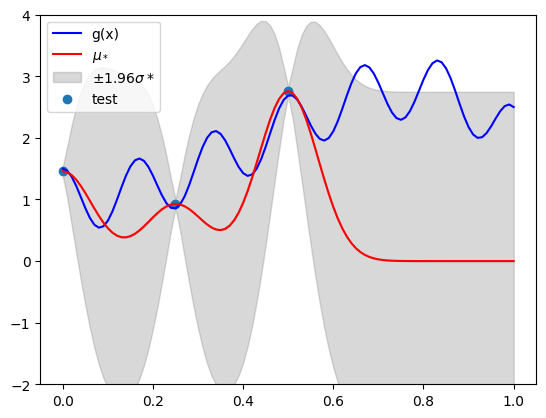

In [ ]:
f_loc, f_cov = gpr2(torch.tensor(X).squeeze(), full_cov=True)
f_var = np.diag(f_cov.detach().numpy())
gp_post_samples = ss.multivariate_normal.rvs(mean=f_loc.detach().numpy(), cov=f_cov.detach().numpy(), size=20)

plt.plot(X, g(X), color = "blue", label = "g(x)")
yout_m = f_loc.detach().numpy()
yout_m = yout_m.reshape(ell,)
yout_v = f_var
plt.plot(X, yout_m, color='red', label=r"$\mu_*$")
plt.fill_between(X.reshape(101,), yout_m, yout_m + 1.96*(yout_v)**0.5, alpha=0.3, color = "grey", label=r"$\pm 1.96 \sigma*$")
plt.fill_between(X.reshape(101,), yout_m, yout_m - 1.96*(yout_v)**0.5, alpha=0.3, color = "grey")
plt.scatter(train_x2,train_y2, label = "test")
plt.legend()
#plt.savefig("f_star_mod1")
plt.ylim(-2,4)
plt.plot()

### B2(4.1)

In [ ]:
def kern(X,Xprime):
    X = X.reshape(-1,1)
    Xprime = Xprime.reshape(-1,1)
    dists = scipy.spatial.distance.cdist(X,Xprime,metric='sqeuclidean')
    return k_variance*np.exp(-0.5*dists / k_lengthscale**2)

In [ ]:
mu_star = kern(train_x2, X).T @ np.linalg.inv(kern(train_x2,train_x2)+ sigma2_y*np.eye(train_x2.shape[0])) @ np.array(train_y2)
sigma_star = kern(X,X)- kern(train_x2, X).T @ np.linalg.inv(kern(train_x2,train_x2) + sigma2_y*np.eye(train_x2.shape[0])) @ kern(train_x2, X)
sigma_star_diag = np.diag(sigma_star)

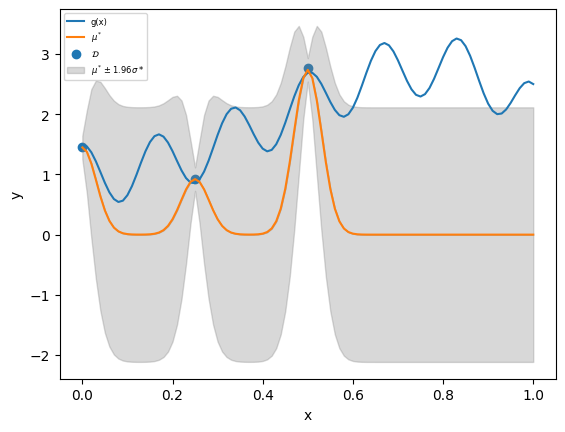

In [ ]:
plt.plot(X, g(X), label = "g(x)")
plt.plot(X, mu_star, label = r"$\mu^*$")
plt.scatter(train_x2, train_y2, label = r"$\mathcal{D}$")
CI_upper = mu_star + 1.96 * sigma_star_diag**0.5
CI_lower = mu_star - 1.96 * sigma_star_diag**0.5
plt.fill_between(X.squeeze(), mu_star, CI_upper, alpha=0.3, color = "grey", label=r"$\mu^*\pm 1.96 \sigma*$")
plt.fill_between(X.squeeze(), mu_star, CI_lower, alpha=0.3, color = "grey")
plt.legend(fontsize="6")
plt.xlabel("x")
plt.ylabel("y")
#plt.savefig("f_D")
plt.show()

### B2(4.2)

In [ ]:
mu_f_qD = mu_star + sigma_star @ W @ np.linalg.inv(W.T@sigma_star@W) @ (2 - W.T @ mu_star)
Sigma_f_qD = sigma_star - sigma_star @ W @np.linalg.inv(W.T @ sigma_star @W) @ W.T @ sigma_star
Sigma_f_qD_diaf = np.diag(Sigma_f_qD)

In [ ]:
samp = np.random.multivariate_normal(mu_f_qD, Sigma_f_qD, size = 5)

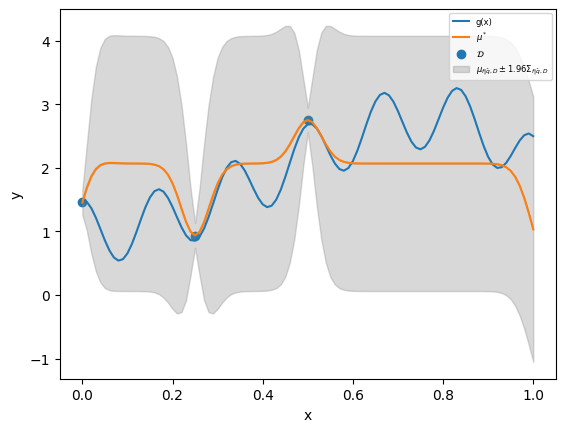

In [ ]:
plt.plot(X, g(X), label = "g(x)")
plt.plot(X, mu_f_qD, label = r"$\mu^*$")
plt.scatter(train_x2, train_y2, label = r"$\mathcal{D}$")
CI_upper = mu_f_qD + 1.96 * Sigma_f_qD_diaf**0.5
CI_lower = mu_f_qD - 1.96 * Sigma_f_qD_diaf**0.5
plt.fill_between(X.squeeze(), mu_f_qD, CI_upper, alpha=0.3, color = "grey", label=r"$\mu_{f|\hat q,D}\pm 1.96 \Sigma_{f|\hat q,D}$")
plt.fill_between(X.squeeze(), mu_f_qD, CI_lower, alpha=0.3, color = "grey")
plt.legend(fontsize="6")
plt.xlabel("x")
plt.ylabel("y")
#plt.savefig("f_qD")
plt.show()

In [ ]:
# Clear the parameter store
pyro.clear_param_store()
# Define the RBF kernel with constant noise
kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(1), lengthscale=torch.tensor(0.05)
)
noise_value = torch.tensor(0.01)
gpr1 = gp.models.GPRegression(train_x, train_y, kernel, noise = noise_value)

# Set priors on the kernel hyperparameters
gpr1.kernel.lengthscale = pyro.nn.PyroSample(dist.HalfNormal(0.05))
gpr1.kernel.variance = pyro.nn.PyroSample(dist.HalfNormal(1))

# Set a prior on the observation noise (noise parameter)

# Set up optimizer and loss function
optimizer = torch.optim.Adam(gpr1.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []

# Training loop
num_steps = 1500
for i in range(num_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr1.model, gpr1.guide)
    loss.backward()
    optimizer.step()
    gpr1.noise = noise_value
    losses.append(loss.item())